In [28]:
.libPaths('/root/miniconda3/envs/Rdoc/lib/R/library')

In [29]:
library(scran)

In [30]:
library(SpatialExperiment)

In [31]:
T = readRDS('./B.rds')

In [32]:
assay(T, "exprs") <- asinh(counts(T)/1)

In [33]:
biggene = c('CD14','FAP','Vimentin','HLA-DR','CD3','CD4','CD8a',
           'CD68')

In [34]:
allgene = rownames(T)

In [35]:
biggene

[1] "CD14"     "FAP"      "Vimentin" "HLA-DR"   "CD3"      "CD4"      "CD8a"    
[8] "CD68"

In [36]:
funcge = setdiff(allgene,biggene)

In [37]:
funcge

[1] "IL-6"      "FoxP3"     "CD69"      "CollagenI" "BCA1"      "CD31"     
 [7] "TIM3"      "PDPN"      "CD103"     "CD276"     "CD71"      "CXCR4"    
[13] "PD-L1"     "CCR7"      "CD11b"     "CD20"      "FosB"      "GranzymeB"
[19] "PD-1"      "Ki-67"     "GATA-3"    "CD45RA"    "TNFa"      "m6A"      
[25] "CD45RO"    "CD57"      "OLR1"      "KLF2"      "NLRP3"     "HIF1a"

In [53]:
funcge = c('IL-6','FoxP3','CD69','BCA1','TIM3','CD71','CXCR4','PD-L1',
           'CCR7','CD11b','CD20','FosB','GranzymeB','PD-1','Ki-67','TNFa',
           'm6A','KLF2','NLRP3','HIF1a')

In [ ]:
library(batchelor)
set.seed(220228)
out <- fastMNN(T, batch = T$sample_id,
               auto.merge = TRUE,
               subset.row = funcge,
               assay.type = "exprs")

# Check that order of cells is the same
stopifnot(all.equal(colnames(T), colnames(out)))

# Transfer the correction results to the main spe object
reducedDim(T, "fastMNN") <- reducedDim(out, "corrected")

Warning message in check_numbers(k = k, nu = nu, nv = nv, limit = min(dim(x)) - :
“more singular values/vectors requested than available”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [ ]:
merge_info <- metadata(out)$merge.info 
merge_info[,c("left", "right", "batch.size")]

In [ ]:
spe =T

In [ ]:
library(scater)
set.seed(220228)
spe <- runUMAP(T, dimred= "fastMNN", name = "UMAP_mnnCorrected") 

In [ ]:
library(Rphenograph)
library(igraph)
library(dittoSeq)

In [ ]:
mat <- t(assay(T, "exprs")[funcge,])
set.seed(230619)
# out <- Rphenograph(mat, k = 25)
# clusters <- factor(membership(out[[2]]))
# spe$pg_clusters_corrected <- clusters

In [ ]:
# dittoDimPlot(spe, var = "pg_clusters_corrected", 
#              reduction.use = "UMAP_mnnCorrected", size = 0.2,
#              do.label = TRUE) +
#     ggtitle("Phenograph clusters on UMAP, integrated cells")

###  bluster

In [ ]:
library(bluster)
library(BiocParallel)
library(ggplot2)

mat <- t(assay(spe, "exprs")[funcge,])

In [ ]:
spe

In [ ]:
combinations <- clusterSweep(mat, 
                             BLUSPARAM=SNNGraphParam(),
                             k=c(10L, 20L), 
                             type = c("rank", "jaccard"), 
                             cluster.fun = "louvain",
                             BPPARAM = MulticoreParam(RNGseed = 220427))

sil <- vapply(as.list(combinations$clusters), 
              function(x) mean(approxSilhouette(mat, x)$width), 
              0)

ggplot(data.frame(method = names(sil),
                  sil = sil)) +
    geom_point(aes(method, sil)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average silhouette width")

pur <- vapply(as.list(combinations$clusters), 
              function(x) mean(neighborPurity(mat, x)$purity), 
              0)

ggplot(data.frame(method = names(pur),
                  pur = pur)) +
    geom_point(aes(method, pur)) +
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    xlab("Cluster parameter combination") +
    ylab("Average neighborhood purity")

set.seed(220621)
clusters <- clusterCells(spe, 
                         use.dimred = "fastMNN", 
                         BLUSPARAM = SNNGraphParam(k = 20, 
                                        cluster.fun = "louvain",
                                        type = "rank"))

spe$nn_clusters_corrected <- clusters

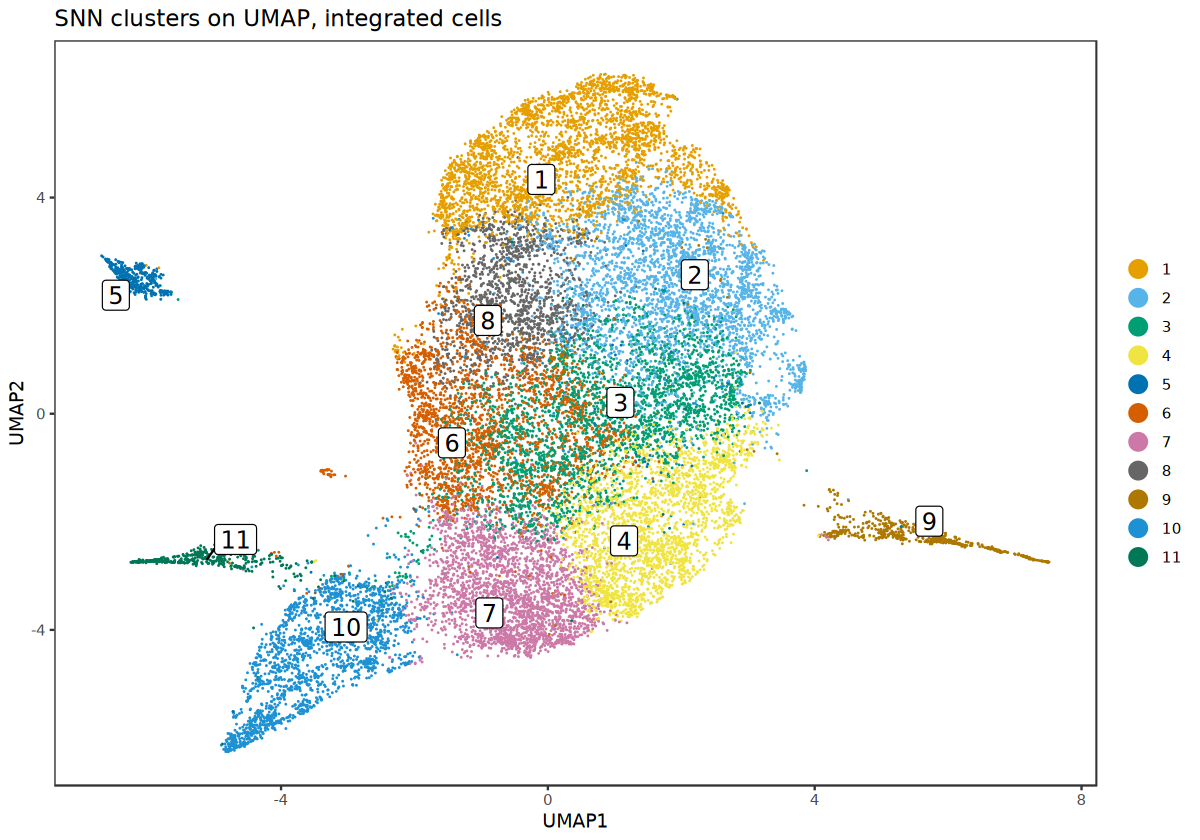

In [72]:
dittoDimPlot(spe, var = "nn_clusters_corrected", 
             reduction.use = "UMAP_mnnCorrected", size = 0.2,
             do.label = TRUE) +
    ggtitle("SNN clusters on UMAP, integrated cells")

In [69]:
library(stringr)

In [ ]:
spe$ROI <- str_sub(spe$sample_id, -3, -1)
spe$patient_id <- str_extract(spe$sample_id, "T00[1-5]")

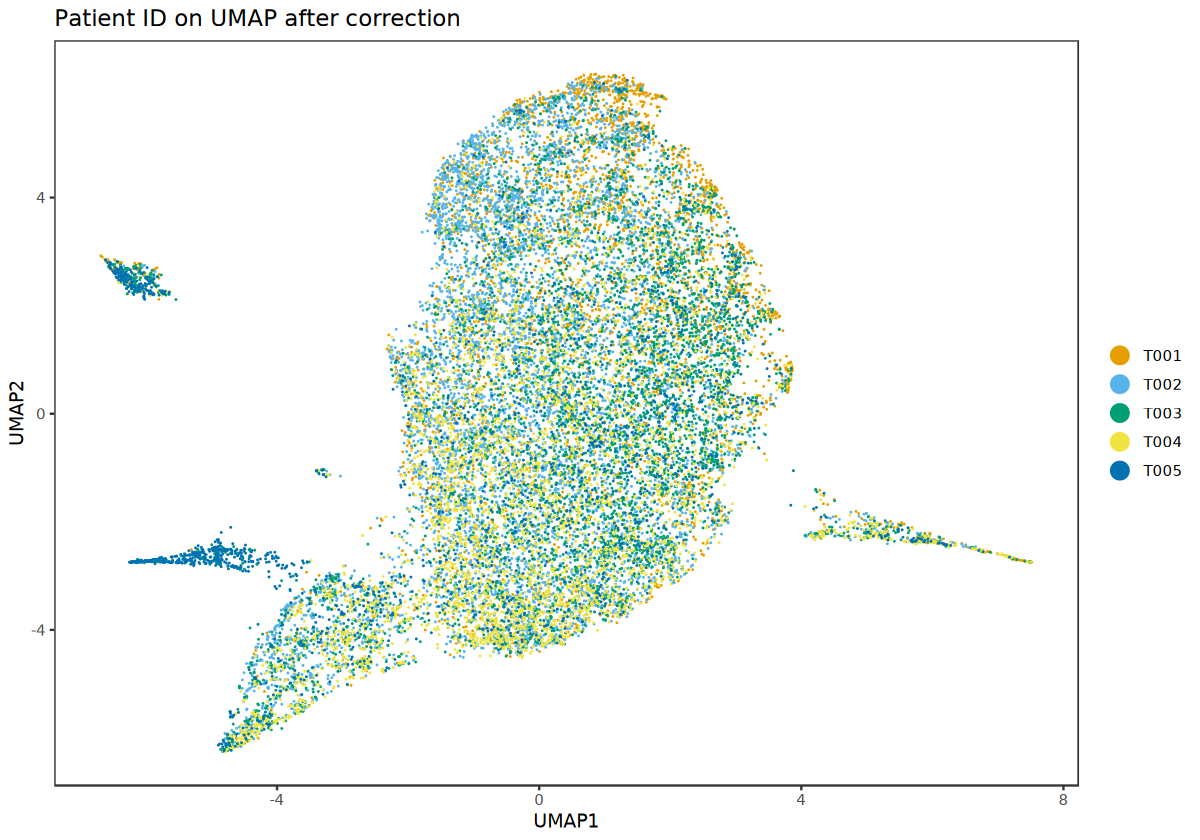

In [71]:
library(cowplot)
library(dittoSeq)
library(viridis)
dittoDimPlot(spe, var = "patient_id", 
                   reduction.use = "UMAP_mnnCorrected", size = 0.2) + 
   #scale_color_manual(values = metadata(spe)$color_vectors$patient_id) +
    ggtitle("Patient ID on UMAP after correction")

In [75]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(spe, "SingleCellExperiment"),  
                     ids = spe$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row =c(funcge,'CD3','CD8a') )

library(dittoSeq)
library(colorspace)
library(viridis)



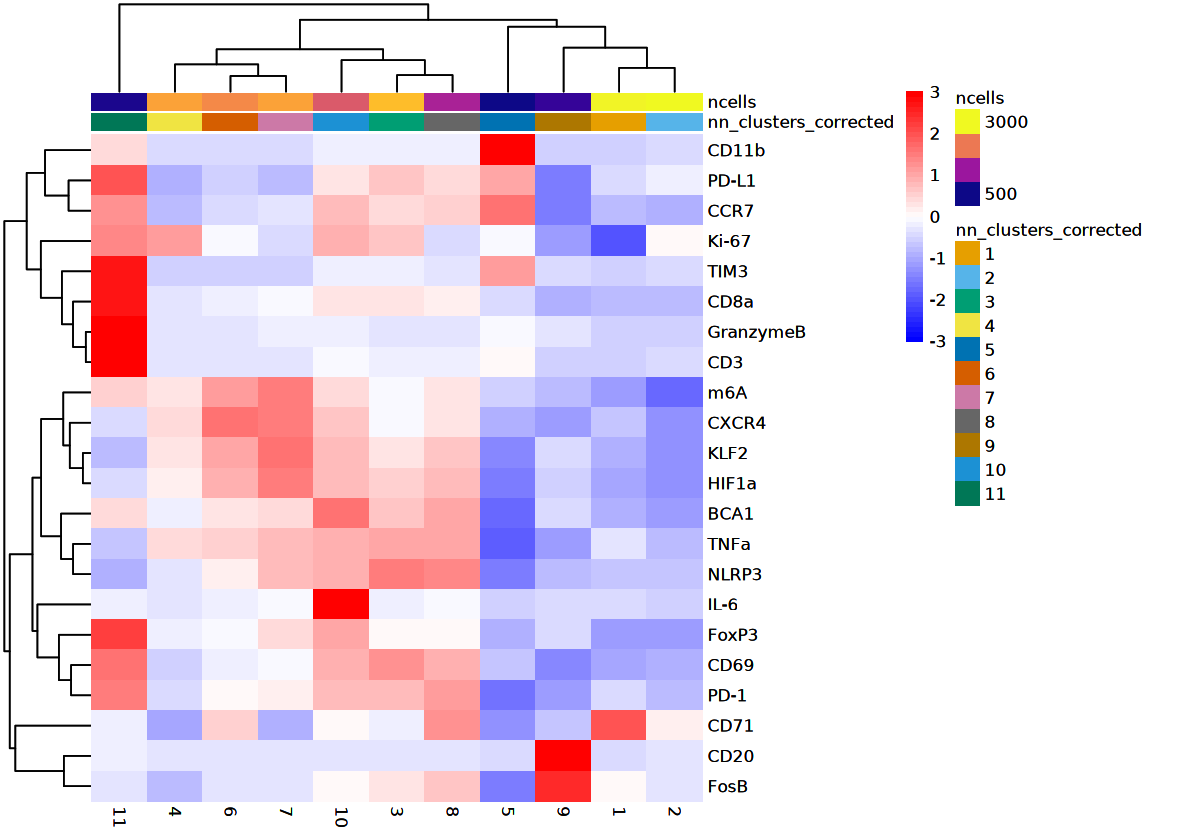

In [76]:
options(repr.plot.width = 10)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(spe)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

### 细胞注释

In [79]:
library(dplyr)
cluster_celltype <- recode(spe$nn_clusters_corrected,
                           '11' = 'unlabel',
                           '9' = 'B_FosB',
                           '1' = 'B_CD71',
                           '2' = 'unlabel',
                           '5' = 'B_CD11b',
                           '10' = 'B_IL6',
                           '3' = 'B_NLRP3',
                           '8' = 'B_NLRP3',
                           '6' = 'B_CXCL4',
                           '7' = 'B_CXCL4',
                           '4' = 'B_KI67'
                                    
)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [80]:
spe$celltype <- cluster_celltype

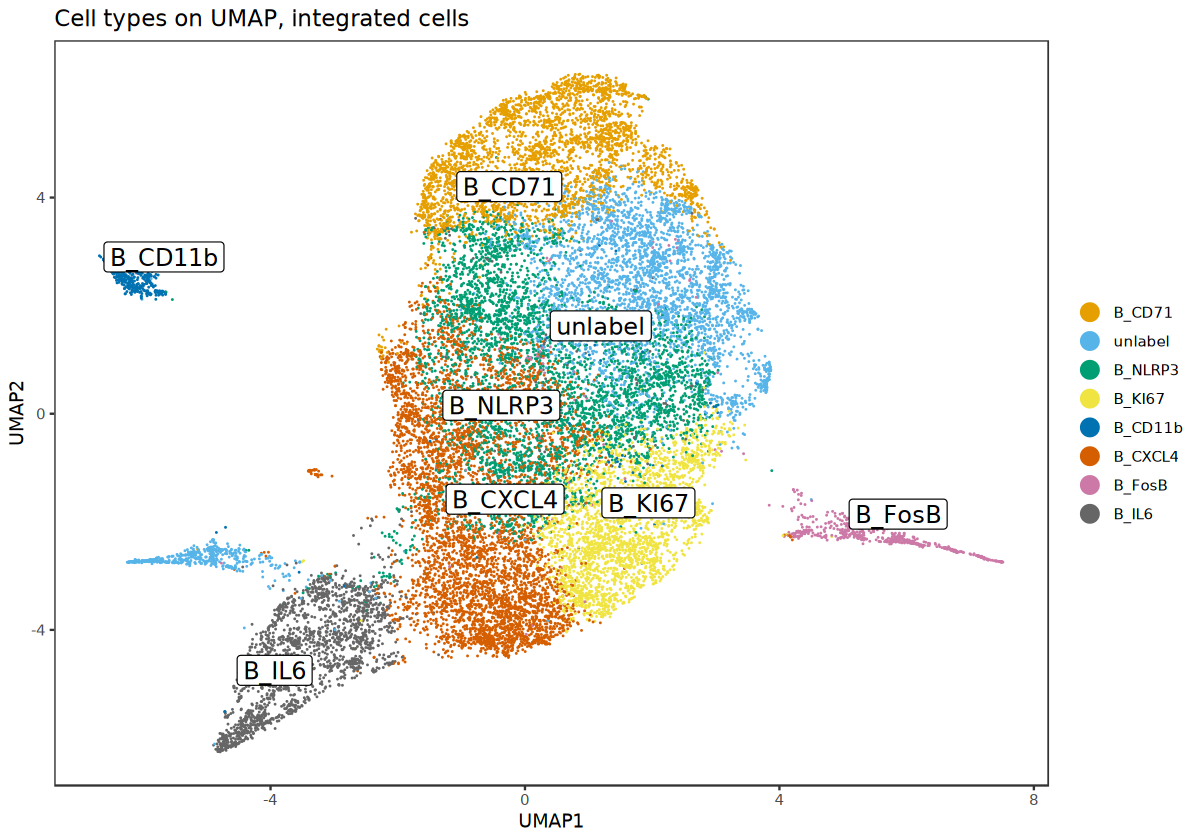

In [81]:
dittoDimPlot(spe, 
                   var = "celltype", 
                   reduction.use = "UMAP_mnnCorrected", 
                   size = 0.2,
                   do.label = TRUE) +
 # scale_color_manual(values = metadata(spe)$color_vectors$celltype) +
  theme(legend.title = element_blank()) +
  ggtitle("Cell types on UMAP, integrated cells")

In [82]:
table(spe$celltype, spe$patient_id)

         
          T001 T002 T003 T004 T005
  B_CD71  1090 1394  366  161   85
  unlabel  892  811  899  401  653
  B_NLRP3  471 1644 1058  747  287
  B_KI67   267  777  679  625  204
  B_CD11b   92   30  120   25  188
  B_CXCL4  516 1831  686 1572  343
  B_FosB   129  120  127  212   65
  B_IL6     77  694  436  553  209

In [95]:
unique(spe$celltype)

[1] B_CD71  unlabel B_NLRP3 B_KI67  B_CD11b B_CXCL4 B_FosB  B_IL6  
Levels: B_CD71 unlabel B_NLRP3 B_KI67 B_CD11b B_CXCL4 B_FosB B_IL6

In [96]:
label = unique(spe$celltype)[-2]

In [97]:
b = spe[,spe$celltype %in% c(label)]

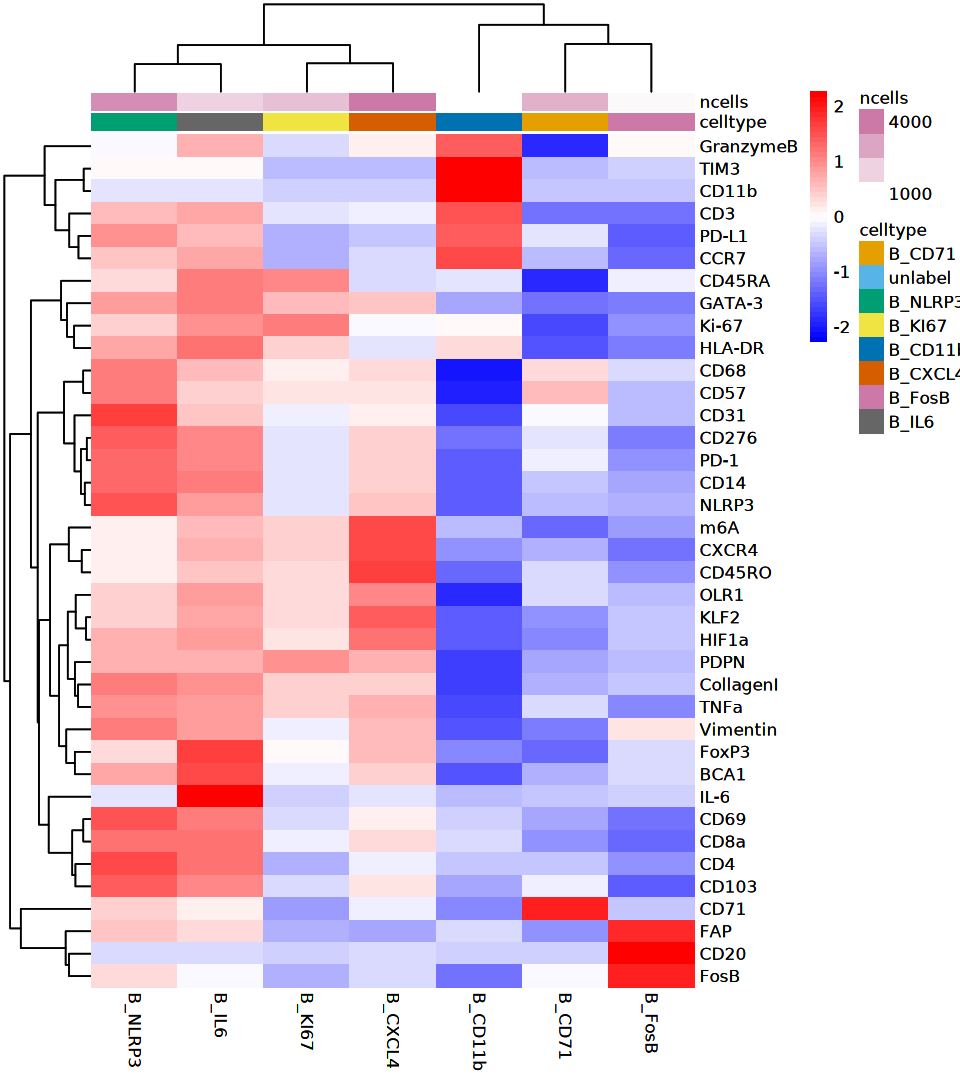

In [98]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(b, "SingleCellExperiment"),  
                     ids = b$celltype, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(b))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 8,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("celltype", "ncells"))

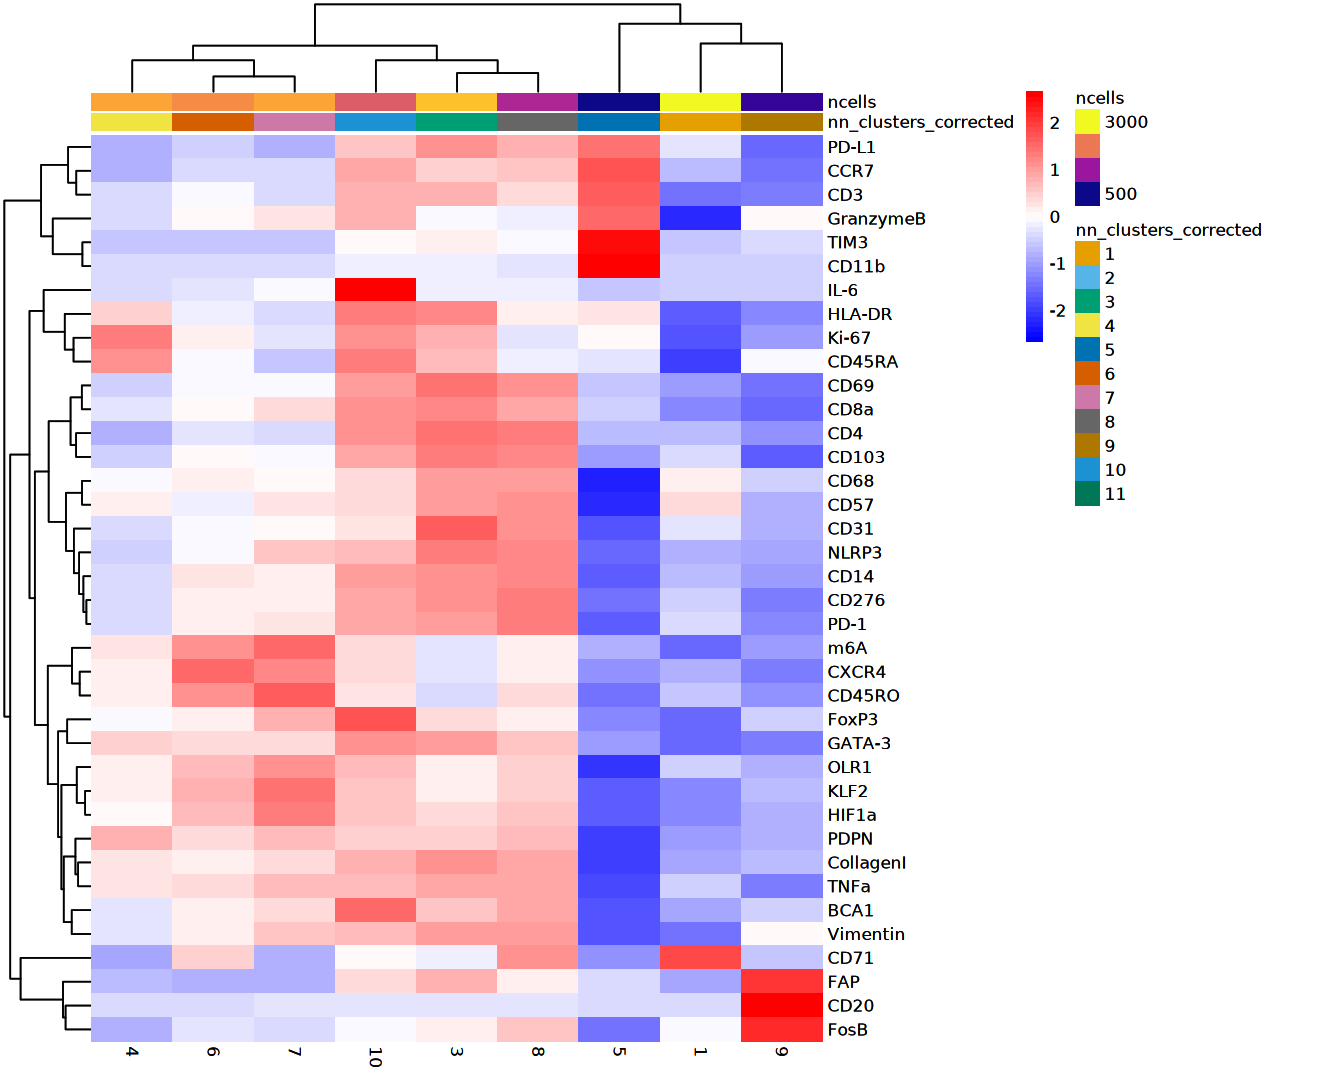

In [99]:
library(scuttle)

## aggregate by cell type
celltype_mean <- aggregateAcrossCells(as(b, "SingleCellExperiment"),  
                     ids = b$nn_clusters_corrected, 
                     statistics = "mean",
                     use.assay.type = "exprs", 
                     subset.row = rownames(b))

library(dittoSeq)
library(colorspace)
library(viridis)

options(repr.plot.width = 11,repr.plot.height = 9)

dittoHeatmap(celltype_mean,
             assay = "exprs", 
             cluster_cols = TRUE, show_rownames = TRUE,show_colnames =TRUE,
             annot.by = c("nn_clusters_corrected", "ncells"),
             annotation_colors = list(celltype = metadata(b)$color_vectors$nn_clusters_corrected,
                                      ncells = plasma(100)))

In [100]:
set.seed(220818)
cur_cells <- sample(seq_len(ncol(b)), 4000)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


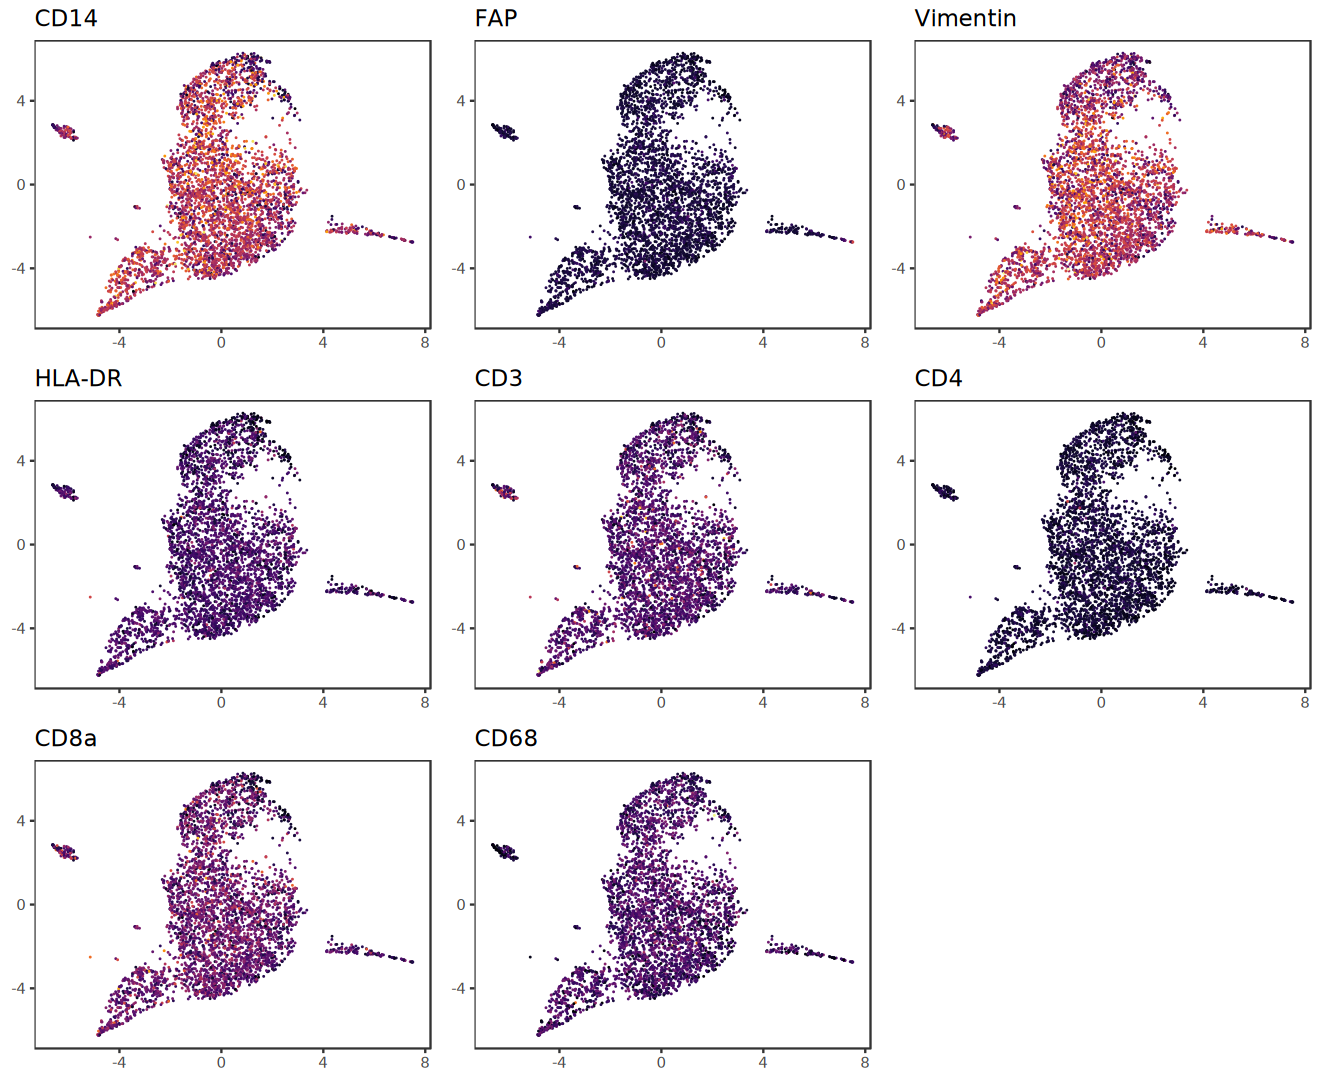

In [101]:
plot_list <- multi_dittoDimPlot(b[,cur_cells], var = biggene, reduction.use = "UMAP_mnnCorrected", 
                   assay = "exprs", size = 0.2, list.out = TRUE) 
plot_list <- lapply(plot_list, function(x) x + scale_color_viridis(option = "B")  )
plot_grid(plotlist = plot_list) 

In [87]:
library(ggsci)

In [88]:
options(repr.plot.width = 14,repr.plot.height = 9)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


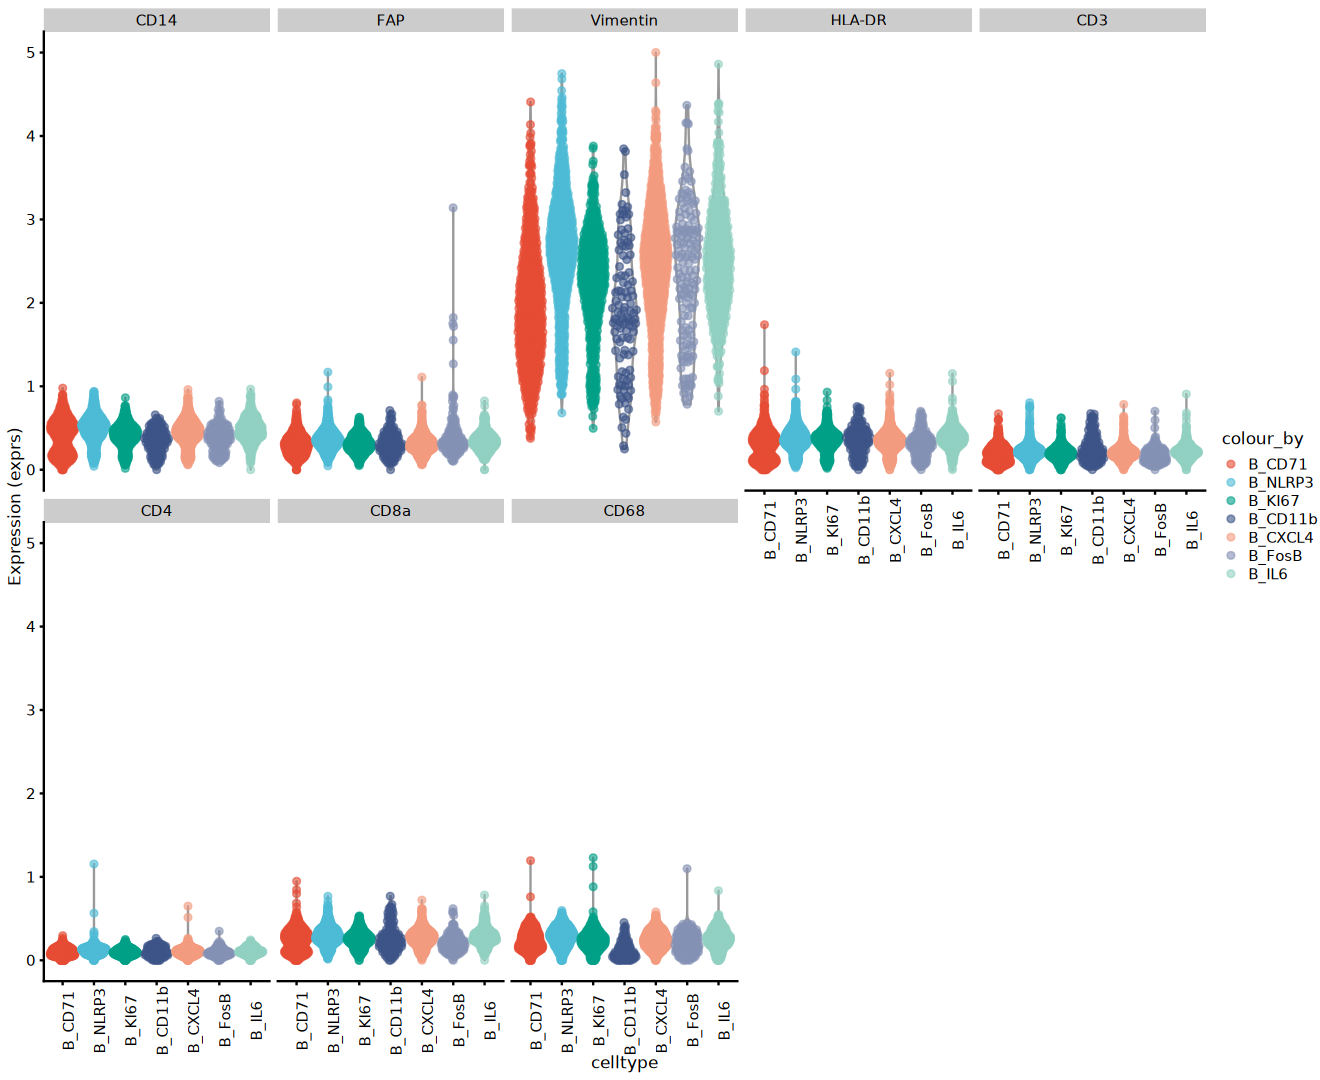

In [102]:
plotExpression(b[,cur_cells], 
               features = biggene, ncol = 5,
               x = "celltype", 
               exprs_values = "exprs", 
               colour_by = "celltype") +
    theme(axis.text.x =  element_text(angle = 90))+
    scale_color_manual(values = pal_npg("nrc")(10))

In [103]:
options(repr.plot.width = 5,repr.plot.height = 6)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


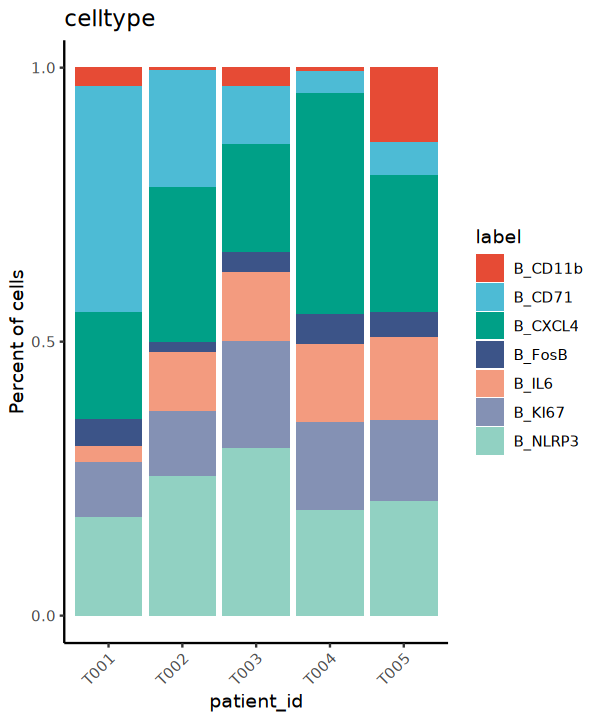

In [104]:
dittoBarPlot(b, 
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = pal_npg("nrc")(10))

In [106]:
saveRDS(b,file = 'b.anno.rds')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


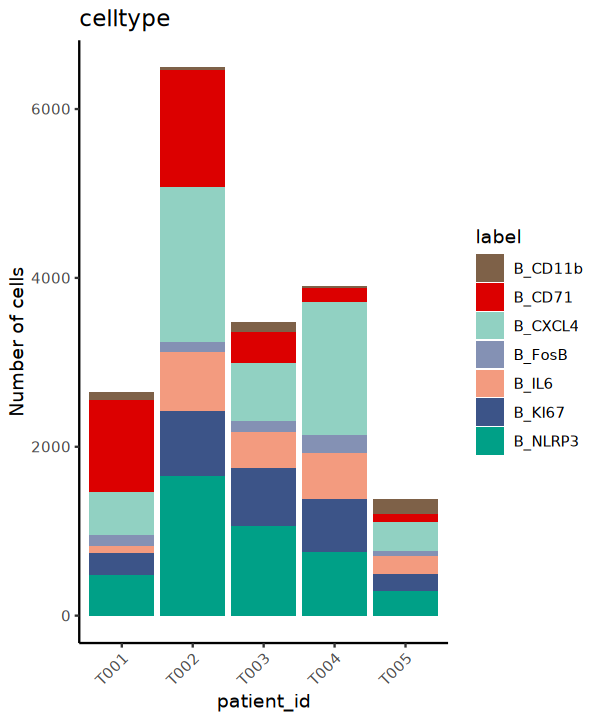

In [107]:
dittoBarPlot(b, 
             scale = "count",
             var = "celltype", 
             group.by = "patient_id") +
    scale_fill_manual(values = rev(pal_npg("nrc")(9)))